# Train Random Forest classifier with Final model (no. 4) and Feature Importance

## Preparation

In [1]:
import csv
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
import os
print(os.getcwd())

C:\Users\NMT\OneDrive - Lancaster University\Dissertation project\Python codes\Classifications\RandomForrest


Load the saved text embeddings

In [3]:
embed_filepathname1 = "../Import/SBERT_raw.csv"
text_embeddings_sep = np.genfromtxt(embed_filepathname1, delimiter=',')
data = text_embeddings_sep

emb_dim = 384
nrow = len(data)
nfeature = int(len(data[0])/emb_dim)

Load label list of model 4 (Revised labels post the cluster merging)

In [4]:
# Read the CSV file
labels = np.genfromtxt('../Import/Revised_Labels_4-WHOLE-SBERT-UMAP-HDBSCAN-None-30-35.csv', delimiter=',')

In [6]:
labels = labels.astype(int)

In [5]:
# Combine main and sub feature names
feature_names = ['{}-{}'.format(main, sub) for main in range(1, nfeature+1) for sub in range(1, emb_dim+1)]

## Split training and test data

In [7]:
from sklearn.model_selection import train_test_split
#X_filtered = reduced_embeddings[labels != -1]
X_filtered = data[labels != -1]
y_filtered = labels[labels != -1]

# Use stratify to ensure at least 2 counts in train data and 1 count in test data for each class
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered)

In [8]:
pd.Series(y_train).value_counts(normalize=False)

8     48
0     38
18    22
1     17
6     14
2     12
3     12
12    11
5     10
10    10
4     10
9     10
16    10
11     8
14     6
17     5
15     5
7      5
13     3
Name: count, dtype: int64

In [9]:
pd.Series(y_test).value_counts(normalize=False)

8     21
0     16
18    10
1      7
2      6
3      6
6      6
12     5
16     4
5      4
9      4
11     4
10     4
4      4
13     2
7      2
14     2
17     2
15     2
Name: count, dtype: int64

## Main classifier training with Initial Exploration (RandomizedSearchCV)

In [43]:
from sklearn.ensemble import RandomForestClassifier

# define the model
model = RandomForestClassifier()

# Import library for Initial exploration with Cross Validation
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],  # The number of trees in the forest
    #'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split
    'max_depth': np.arange(3, 10, 1),  # The maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 3, 5],  # The minimum number of samples required to be at a leaf node
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4],  # The minimum weighted fraction of the sum total of weights required to be at a leaf node
    #'max_features': ['auto', 'sqrt', 'log2', None],  # The number of features to consider when looking for the best split
    'max_leaf_nodes': [None, 10, 30, 50],  # Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity
    'min_impurity_decrease': [0.0, 0.1, 0.2],  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
    #'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    #'oob_score': [True, False],  # Whether to use out-of-bag samples to estimate the generalization accuracy
    'class_weight': [None, 'balanced', 'balanced_subsample']  # Weights associated with classes in the form {class_label: weight}
}

# Create RandomForestClassifier object
rf_clf = RandomForestClassifier(random_state=42)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_grid,
    n_iter=500,
    scoring='accuracy',
    n_jobs=1,
    cv=2,
    verbose=2,
    random_state=42
)

# Fit the RandomizedSearchCV object
#random_search.fit(X_filtered, y_filtered)
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
[CV] END class_weight=None, max_depth=8, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=10, min_weight_fraction_leaf=0.2, n_estimators=500; total time=   1.3s
[CV] END class_weight=None, max_depth=8, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=10, min_weight_fraction_leaf=0.2, n_estimators=500; total time=   1.3s
[CV] END class_weight=None, max_depth=6, max_leaf_nodes=10, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=10, min_weight_fraction_leaf=0.4, n_estimators=200; total time=   0.5s
[CV] END class_weight=None, max_depth=6, max_leaf_nodes=10, min_impurity_decrease=0.1, min_samples_leaf=5, min_samples_split=10, min_weight_fraction_leaf=0.4, n_estimators=200; total time=   0.5s
[CV] END class_weight=None, max_depth=9, max_leaf_nodes=30, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=10, min_weight_fraction_lea

In [44]:
best_params

{'n_estimators': 500,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'min_impurity_decrease': 0.0,
 'max_leaf_nodes': 30,
 'max_depth': 8,
 'class_weight': 'balanced_subsample'}

### Obtain best CV score = accuracy of training data

In [45]:
random_search.best_score_

0.6484375

### Obtain accuracy of test data

In [46]:
from sklearn.metrics import accuracy_score

# Extract the best model
best_rfc = random_search.best_estimator_

# Predict the labels of the test set
y_pred = best_rfc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6216216216216216


## Refined Search with Cross Validation (GridSearchCV)

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# define the model
model = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [300, 500, 700],  # The number of trees in the forest
    #'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split
    'max_depth': [7, 8, 9],  # The maximum depth of the tree
    'min_samples_split': [4, 5, 6],  # The minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 3, 4],  # The minimum number of samples required to be at a leaf node
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],  # The minimum weighted fraction of the sum total of weights required to be at a leaf node
    #'max_features': ['auto', 'sqrt', 'log2', None],  # The number of features to consider when looking for the best split
    'max_leaf_nodes': [20, 30, 40],  # Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity
    'min_impurity_decrease': [0.0, 0.1],  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
    #'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    #'oob_score': [True, False],  # Whether to use out-of-bag samples to estimate the generalization accuracy
    'class_weight': ['balanced', 'balanced_subsample']  # Weights associated with classes in the form {class_label: weight}
}

# Create RandomForestClassifier object
rf_clf = RandomForestClassifier(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=1,
    cv=2,
    verbose=2
)

# Fit the RandomizedSearchCV object
#random_search.fit(X_filtered, y_filtered)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_final = grid_search.best_params_

Fitting 2 folds for each of 2916 candidates, totalling 5832 fits
[CV] END class_weight=balanced, max_depth=7, max_leaf_nodes=20, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=300; total time=   3.2s
[CV] END class_weight=balanced, max_depth=7, max_leaf_nodes=20, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=300; total time=   3.0s
[CV] END class_weight=balanced, max_depth=7, max_leaf_nodes=20, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=500; total time=   5.3s
[CV] END class_weight=balanced, max_depth=7, max_leaf_nodes=20, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=500; total time=   5.3s
[CV] END class_weight=balanced, max_depth=7, max_leaf_nodes=20, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=4, min_wei

In [48]:
best_params_final

{'class_weight': 'balanced',
 'max_depth': 8,
 'max_leaf_nodes': 20,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 700}

In [49]:
grid_search.best_score_

0.69140625

In [50]:
from sklearn.metrics import accuracy_score

# Extract the best model
best_rfc_final = grid_search.best_estimator_

# Predict the labels of the test set
y_pred_final = best_rfc_final.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_final))

Accuracy: 0.7207207207207207


## Feature Importance with Built-in method

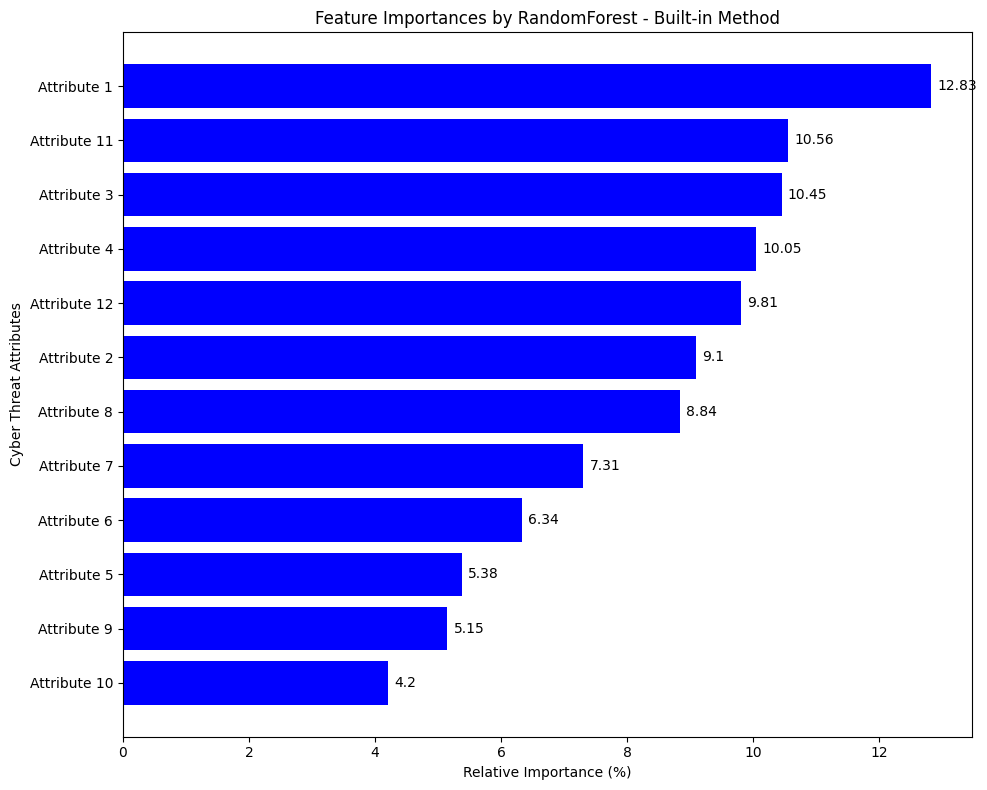

In [58]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_rfc_final.feature_importances_

#for i, importance in enumerate(importances):
#    print(f"Feature {i}: {importance}")

feature_importance_main =  np.array([np.sum(importances[main*emb_dim:(main+1)*emb_dim]) for main in range(nfeature)])

# Normalize the importances so they sum to 1 (or 100%)
feature_importances_percentage = (feature_importance_main / feature_importance_main.sum()) * 100

# Sort the importances in descending order
sorted_indices = np.argsort(feature_importances_percentage)
sorted_importances = feature_importances_percentage[sorted_indices]

# Corresponding main feature labels (1 to 12)
features = [f"Attribute {i}" for i in range(1, nfeature+1)]
sorted_features = [features[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_features, sorted_importances, color='blue')

# Add values next to the bars
for bar in bars:
    xval = bar.get_width()  # Get the width of the bar (its length)
    plt.text(xval + 0.1, bar.get_y() + bar.get_height()/2, round(xval, 2), 
             ha='left', va='center')  # Adjust horizontal position after the bar

plt.ylabel("Cyber Threat Attributes")
plt.xlabel("Relative Importance (%)")
plt.title("Feature Importances by RandomForest - Built-in Method")
plt.tight_layout()

# Save the plot
plt.savefig('Feature Importances by RandomForest - Built-in Method.png', dpi=300, bbox_inches='tight')

plt.show()

## Feature Importance with external method - SHAP

In [52]:
import shap

# create the explainer object with the random forest model
explainer = shap.TreeExplainer(best_rfc_final)

# calculate shap values on the test set
shap_values = explainer.shap_values(X_test)
#shap_values = explainer.shap_values(X_train)

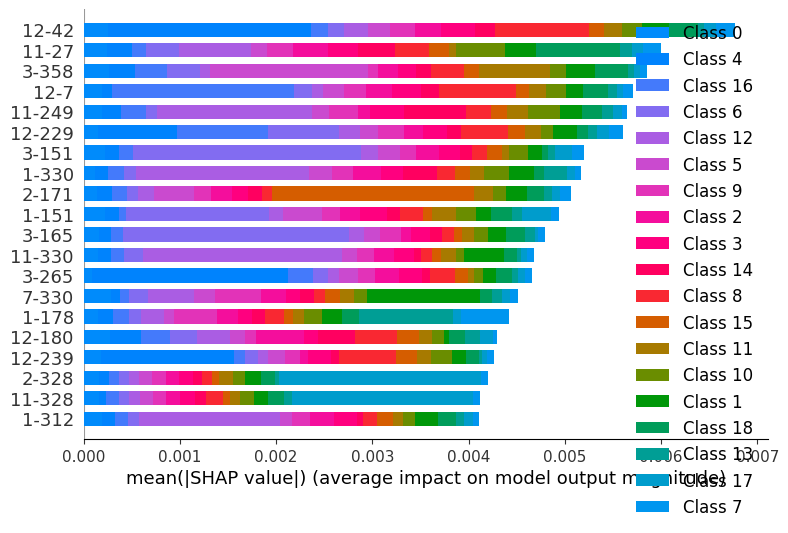

In [53]:
# built-in summary plot the SHAP values (for reference only)
#shap.summary_plot(shap_values, X_test, feature_names=iris.feature_names)
shap.summary_plot(shap_values, feature_names=feature_names, plot_size=0.2)

In [54]:
# for multi-class classification, you can sum the absolute SHAP values over all classes
feature_importance = np.sum(np.abs(shap_values), axis=0).mean(0)

In [55]:
# Further sum the SHAP values for all threat attributes
feature_importance_main =  np.array([np.sum(feature_importance[main*emb_dim:(main+1)*emb_dim]) for main in range(nfeature)])

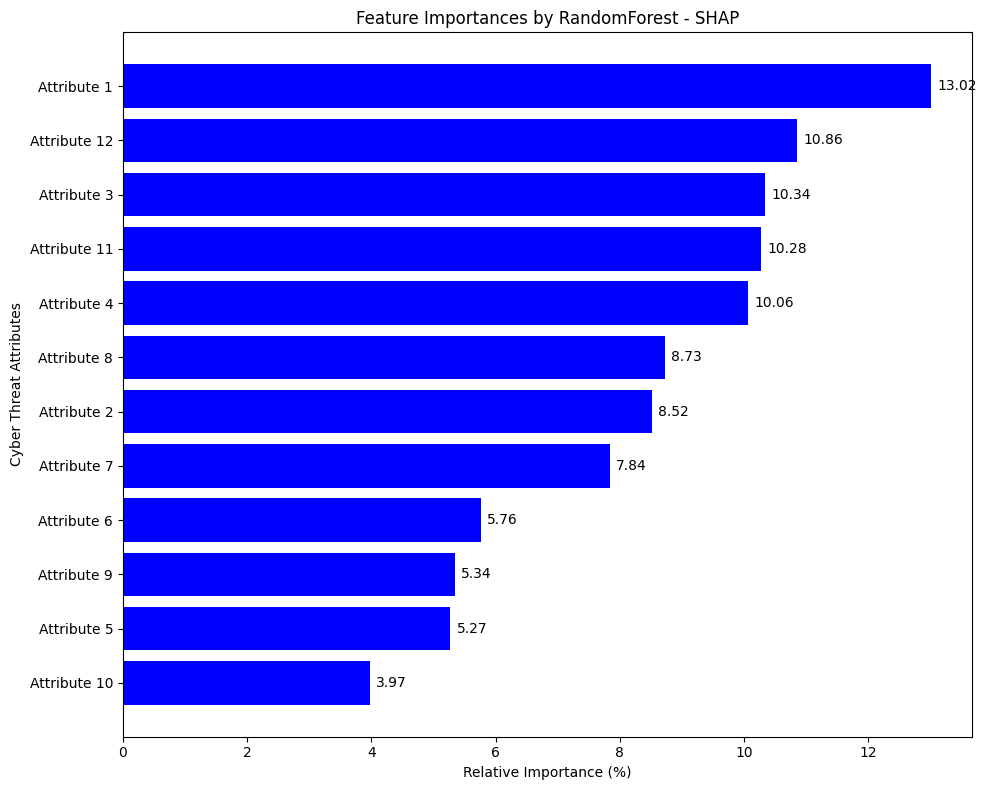

In [57]:
import matplotlib.pyplot as plt

# Normalize the importances so they sum to 1 (or 100%)
feature_importances_percentage = (feature_importance_main / feature_importance_main.sum()) * 100

# Sort the importances in descending order
sorted_indices = np.argsort(feature_importances_percentage)
sorted_importances = feature_importances_percentage[sorted_indices]

# Corresponding main feature labels (1 to 12)
features = [f"Attribute {i}" for i in range(1, nfeature+1)]
sorted_features = [features[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_features, sorted_importances, color='blue')

# Add values next to the bars
for bar in bars:
    xval = bar.get_width()  # Get the width of the bar (its length)
    plt.text(xval + 0.1, bar.get_y() + bar.get_height()/2, round(xval, 2), 
             ha='left', va='center')  # Adjust horizontal position after the bar

plt.ylabel("Cyber Threat Attributes")
plt.xlabel("Relative Importance (%)")
plt.title("Feature Importances by RandomForest - SHAP")
plt.tight_layout()

# Save the plot
plt.savefig('Feature Importances by RandomForest - SHAP.png', dpi=300, bbox_inches='tight')

plt.show()
